In [1]:
import pandas as pd
import numpy as np

In [2]:
from torchvision import transforms
import torchvision.models as models
import pandas as pd
from PIL import Image
import io

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
import torch.nn.functional as F

#

In [5]:
df = pd.read_csv("/kaggle/input/pokemon-llava-images-and-text-descriptions/train.csv")

In [6]:
print(len(df))

833


In [7]:
df.head()

,image,text
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,A cartoon drawing of a green Pokemon with a le...
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,A cartoon character with a red face and a gree...
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,A cartoon character with a red face and white ...
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,A white and pink cartoon character with a smil...
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,A group of cartoon characters with different e...


In [8]:


image_bytes = eval(df.loc[0, 'image'])['bytes']  # Convert string to dict and extract bytes
image = Image.open(io.BytesIO(image_bytes))  # Convert bytes to an image

# Display the imagep
print(image)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x1280 at 0x7D5E2F222050>


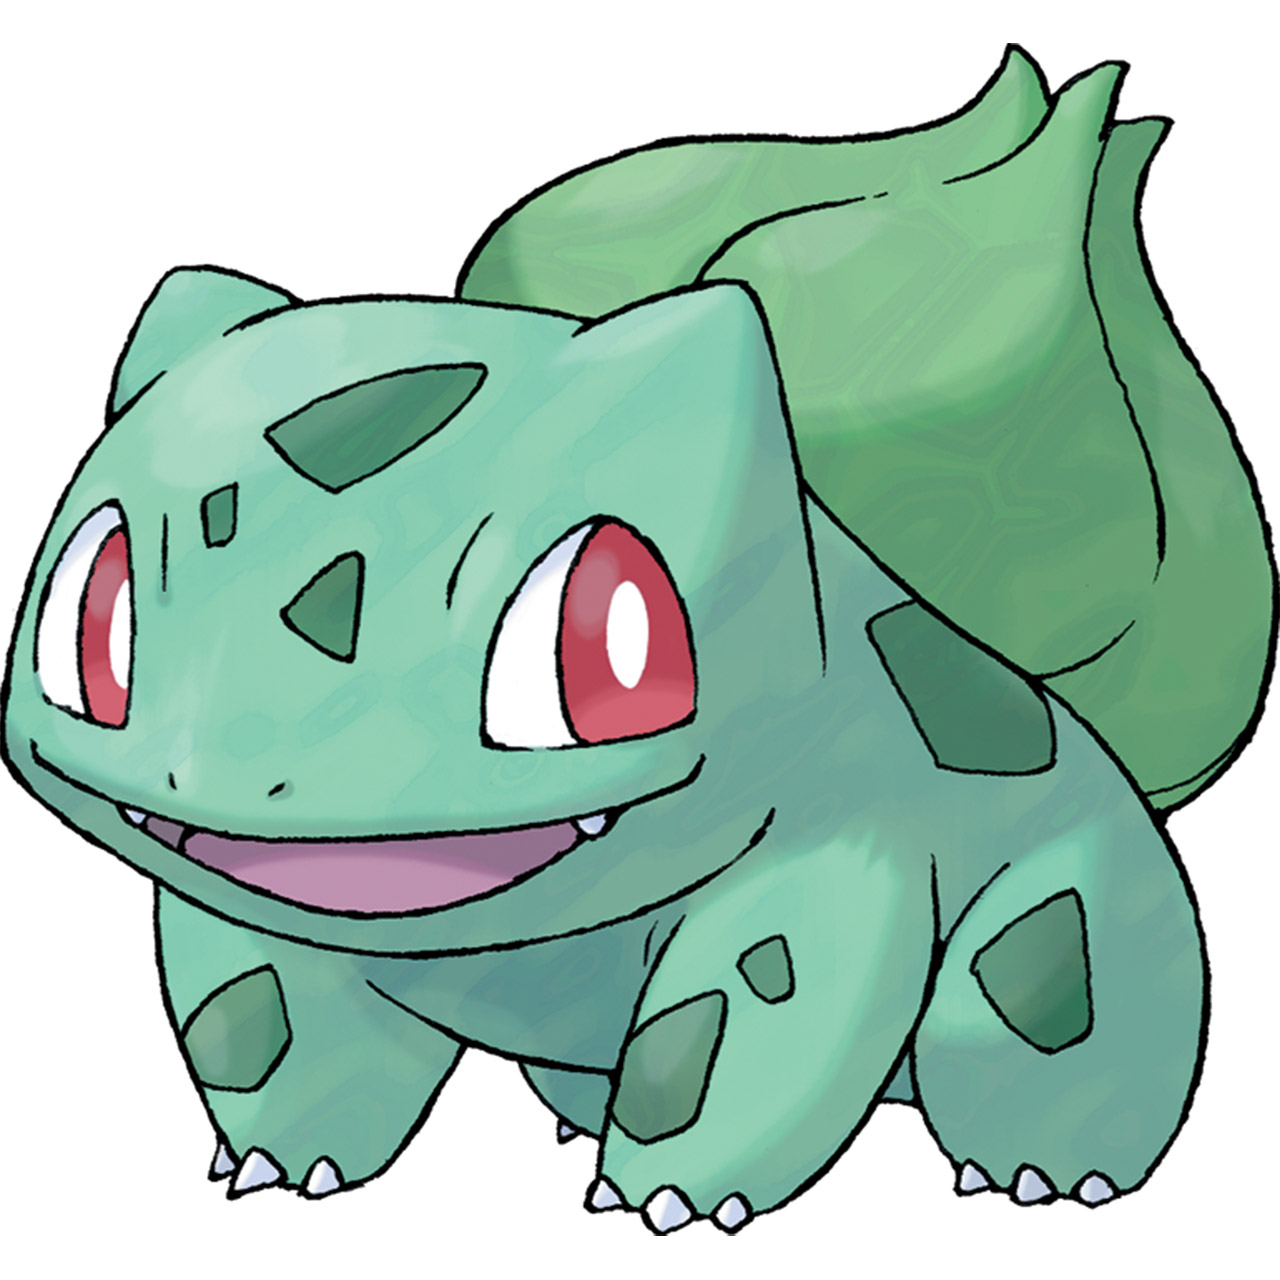

In [9]:
image

In [10]:
# Define transformation: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),  # Converts PIL image to tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Function to convert image bytes to normalized tensor
def image_to_tensor(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")  # Convert bytes to PIL Image
    return transform(image)  # Apply transformation to convert and normalize

# Load image tensors from the DataFrame
image_tensors = []

for _, row in df.iterrows():
    image_bytes = eval(row['image'])['bytes']  # Extract bytes
    tensor = image_to_tensor(image_bytes)  # Convert and normalize
    image_tensors.append(tensor)

print(len(image_tensors))  # Output: torch.Size([N, C, H, W])

833


# Dataset and Dataloader

In [11]:
from torch.utils.data import Dataset, DataLoader

In [12]:
import torch
from torch.utils.data import Dataset

# --- Vocabulary Building ---
def build_vocab(captions):
    vocab = {}
    idx = 4  # Starting index for words.
    for seq in captions:
        for word in seq.split():
            if word not in vocab:
                vocab[word] = idx
                idx += 1

    # Define special tokens.
    vocab['PAD'] = 0
    vocab['UNK'] = 1
    vocab['SOS'] = 2
    vocab['EOS'] = 3

    idx2text = {value: key for key, value in vocab.items()}

    return vocab, idx2text

# Suppose you already have your DataFrame `df` and you extract captions:
caps = []
for _, row in df.iterrows():
    caps.append(row['text'])

text2idx, idx2text = build_vocab(caps)
print(text2idx)
print(idx2text)

# --- Custom Dataset ---
class MyDataset(Dataset):
    def __init__(self, images, captions, text2idx):
        """
        Args:
            images: A list (or tensor) of image tensors.
            captions: A list of caption strings.
            text2idx: Dictionary mapping words to indices. Must include 'SOS', 'EOS', 'PAD', 'UNK'.
        """
        self.images = images
        self.captions = captions
        self.text2idx = text2idx

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        cap = self.captions[idx]
        
        tokens = cap.split() # Split the caption into words.
        
        tokens = ['SOS'] + tokens + ['EOS'] # Append <<start>> and <<end>>
      
        cap_indices = torch.tensor(
            [self.text2idx.get(token, self.text2idx['UNK']) for token in tokens], # Unknown
            dtype=torch.long
        )
        return image, cap_indices

def collate_fn(batch):
    images, captions = zip(*batch)
    
    max_len = max(cap.size(0) for cap in captions)
    pad_token = text2idx['PAD']

    # Padding 
    padded_captions = [
        torch.cat([cap, torch.full((max_len - cap.size(0),), pad_token, dtype=torch.long)])
        for cap in captions
    ]
    images_tensor = torch.stack(images)
    captions_tensor = torch.stack(padded_captions)
    return images_tensor, captions_tensor

{'A': 4, 'cartoon': 5, 'drawing': 6, 'of': 7, 'a': 8, 'green': 9, 'Pokemon': 10, 'with': 11, 'leaf': 12, 'on': 13, 'its': 14, 'back.': 15, 'character': 16, 'red': 17, 'face': 18, 'and': 19, 'body.': 20, 'white': 21, 'ears.': 22, 'pink': 23, 'smiling': 24, 'face.': 25, 'group': 26, 'characters': 27, 'different': 28, 'expressions.': 29, 'big': 30, 'smile': 31, 'head.': 32, 'skeleton': 33, 'head': 34, 'helmet.': 35, 'is': 36, 'holding': 37, 'bone': 38, 'in': 39, 'mouth.': 40, 'large': 41, 'foot': 42, 'claws.': 43, 'wearing': 44, 'blue': 45, 'dress': 46, 'boxing': 47, 'gloves.': 48, 'tongue': 49, 'sticking': 50, 'out.': 51, 'skull': 52, 'crossbones': 53, "it's": 54, 'chest.': 55, 'eye': 56, 'purple': 57, 'forehead.': 58, 'grey': 59, 'dinosaur': 60, 'long': 61, 'horn.': 62, 'dragon': 63, 'tail': 64, 'an': 65, 'egg.': 66, 'body': 67, 'feet.': 68, 'small': 69, 'are': 70, 'standing': 71, 'next': 72, 'to': 73, 'each': 74, 'other.': 75, 'baby': 76, 'stomach.': 77, 'fish': 78, 'tail.': 79, 'nose'

#

In [13]:
train_dataset = MyDataset(image_tensors, caps, text2idx)
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

In [14]:
for image, cap in train_dataloader:
    print(image.shape)
    break

torch.Size([5, 3, 800, 800])


# Testing Resnet

In [15]:
resnet = models.resnet50(pretrained=True)
# Remove the final average pooling and fully-connected layers.
modules = list(resnet.children())[:-2]  
cnn = nn.Sequential(*modules)  # Output channels: 2048

for image, cap in train_dataloader:
    cnn_feats = cnn(image)  # [batch_size, 2048, H', W']
    print(cnn_feats.shape)
    break

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 226MB/s]


torch.Size([5, 2048, 25, 25])


# Model

In [16]:
device='cuda'# 'cuda' or 'cpu'

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [18]:
""" Positional Encoding """
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        pe.requires_grad = False  # we don't need to compute gradient
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) *
                             (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1)]
        return x

""" Image Captioning with ResNet feature extraction, with explicit device transfers """
class ImageCaptioningTransformerResNet(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_heads=8, num_layers=6, dropout=0.1, device=torch.device('cpu')):
        super(ImageCaptioningTransformerResNet, self).__init__()
        self.d_model = d_model
        self.device = device

        # Load a pretrained ResNet50 model.
        resnet = models.resnet50(pretrained=True)
        # Remove the final average pooling and fully-connected layers.
        modules = list(resnet.children())[:-2]  
        self.cnn = nn.Sequential(*modules)  # Output channels: 2048
        
        # Project CNN features to d_model.
        self.conv_proj = nn.Conv2d(2048, d_model, kernel_size=1)
        
        
        # Embedding layer for captions.
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        
        
        # Transformer Decoder.
        decoder_layer = nn.TransformerDecoderLayer(d_model, num_heads, dim_feedforward=2048, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Final output layer.
        # self.fc_pre = nn.Linear(d_model, d_model * 2)
        # self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, vocab_size)
    
    def forward(self, images, captions):
        """
        images: [batch_size, 3, H, W]
        captions: [batch_size, seq_len] (e.g., [[1,2,3], [2,3,2]])
        """
        # Ensure inputs are on the proper device.
        images = images.to(self.device)
        captions = captions.to(self.device)

        # Extract CNN features.
        cnn_feats = self.cnn(images)  # [batch_size, 2048, H', W']
        cnn_feats_proj = self.conv_proj(cnn_feats)  # [batch_size, d_model, H', W']
        # cnn_feats_proj = cnn_feats_proj.flatten(2)  # [batch_size, d_model, num_regions]

        batch, d, hnew, wnew = cnn_feats_proj.shape

        pooled_feats = torch.nn.functional.adaptive_avg_pool2d(cnn_feats_proj, (hnew // 5, wnew // 5))
        pooled_feats_flat = pooled_feats.flatten(2)  # [batch_size, d_model, n_h * n_w]
        memory = pooled_feats_flat.transpose(1, 2).transpose(0, 1)  # [n_h * n_w, batch_size, d_model]
        
        """ Process captions """
        # Embed captions and scale.
        caption_embeds = self.embedding(captions) * (self.d_model ** 0.5)
        caption_embeds = self.pos_encoder(caption_embeds)  # [batch_size, seq_len, d_model]
        # Prepare target for the Transformer: [seq_len, batch_size, d_model]
        tgt = caption_embeds.transpose(0, 1)
        
        # Create target mask on self.device.
        seq_len = tgt.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(self.device)
        
        # Transformer decoder output: [seq_len, batch_size, d_model]
        output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)
        output = output.transpose(0, 1)  # [batch_size, seq_len, d_model]
        
        # Project to vocabulary.
        # logits = self.fc_out(self.dropout(self.fc_pre(output)))  # [batch_size, seq_len, vocab_size]
        logits = self.fc_out(output)
        return logits

# Test output of model.
if __name__ == "__main__":
    # Hyperparameters and dummy data.
    vocab_size = len(text2idx)    # Example vocabulary size.
    batch_size = 2
    seq_len = 15           # Example caption length
    
    # Create dummy image and caption tensors on the correct device.
    dummy_images = torch.rand(batch_size, 3, 224, 224).to(device)
    dummy_captions = torch.randint(0, vocab_size, (batch_size, seq_len)).to(device)
    
    # Initialize the model with the specified device.
    model_test = ImageCaptioningTransformerResNet(vocab_size=vocab_size, device=device)
    model_test.to(device)
    # Forward pass.
    logits = model_test(dummy_images, dummy_captions)
    print("Logits shape:", logits.shape)  # Expected: [batch_size, seq_len, vocab_size]
    
    # Example: compute loss (using CrossEntropyLoss).
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits.view(-1, vocab_size), dummy_captions.view(-1))
    print("Dummy loss:", loss.item())


Logits shape: torch.Size([2, 15, 520])
Dummy loss: 6.453726768493652


# Train Function

In [19]:
""" Train function """
def train(model, dataloader, optimizer, criterion, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (images, captions) in enumerate(dataloader):
            images = images.to(device)
            captions = captions.to(device)

            #
            optimizer.zero_grad()
            output = model(images, captions[:, :-1])
            output_reshape = output.contiguous().view(-1, output.shape[-1]) # [Batch_size, seq_len - 1, vocab_size]
            captions = captions[:, 1:].contiguous().view(-1) # Get all token but except the first one.
    
            loss = criterion(output_reshape, captions)
            loss.backward()
            optimizer.step()
    
            epoch_loss += loss.item()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/10:.4f}")

    print("Training OK!")

## Dummy dataloader for testing

In [20]:

dummy_images = [torch.rand(3, 224, 224) for _ in range(5)]
dummy_captions = [
    "a dog is running",
    "a cat is sleeping on the mat",
    "a bird is flying",
    "a man is playing guitar",
    "a woman is riding a bicycle"
]

# Build vocabulary using dummy captions (in practice, use your df captions).
# text2idx, idx2text = build_vocab(dummy_captions)
# print("Vocabulary:", text2idx)

# Create dataset and DataLoader.
dataset = MyDataset(dummy_images, dummy_captions, text2idx)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Iterate over the DataLoader.
for images_batch, captions_batch in dataloader:
    print("Images batch shape:", images_batch.shape)    # Expected: [batch_size, 3, 224, 224]
    print("Captions batch shape:", captions_batch.shape)  # Expected: [batch_size, seq_len]
    print("Captions batch:", captions_batch)
    break

Images batch shape: torch.Size([2, 3, 224, 224])
Captions batch shape: torch.Size([2, 7])
Captions batch: tensor([[  2,   8,   1,  36,   1,   1,   3],
        [  2,   8, 129,  36,   1,   3,   0]])


# Result

In [21]:
model = model = ImageCaptioningTransformerResNet(vocab_size=len(text2idx), device=device)
model.to(device)
# Loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [22]:
# Train the model.
train(model, train_dataloader, optimizer, criterion, device, num_epochs=80)

Epoch [1/80], Loss: 41.3076
Epoch [2/80], Loss: 29.1477
Epoch [3/80], Loss: 26.1578
Epoch [4/80], Loss: 23.8878
Epoch [5/80], Loss: 22.1282
Epoch [6/80], Loss: 20.4224
Epoch [7/80], Loss: 18.9125
Epoch [8/80], Loss: 17.4962
Epoch [9/80], Loss: 15.9168
Epoch [10/80], Loss: 14.2760
Epoch [11/80], Loss: 13.0808
Epoch [12/80], Loss: 11.6210
Epoch [13/80], Loss: 10.4351
Epoch [14/80], Loss: 9.6424
Epoch [15/80], Loss: 8.1971
Epoch [16/80], Loss: 7.0952
Epoch [17/80], Loss: 6.1390
Epoch [18/80], Loss: 5.4417
Epoch [19/80], Loss: 4.6906
Epoch [20/80], Loss: 3.9440
Epoch [21/80], Loss: 3.3173
Epoch [22/80], Loss: 2.8481
Epoch [23/80], Loss: 2.5545
Epoch [24/80], Loss: 2.1478
Epoch [25/80], Loss: 1.8896
Epoch [26/80], Loss: 1.9808
Epoch [27/80], Loss: 1.7318
Epoch [28/80], Loss: 1.5023
Epoch [29/80], Loss: 1.3954
Epoch [30/80], Loss: 1.3039
Epoch [31/80], Loss: 1.2911
Epoch [32/80], Loss: 0.9421
Epoch [33/80], Loss: 0.8619
Epoch [34/80], Loss: 0.8486
Epoch [35/80], Loss: 1.3929
Epoch [36/80], L

In [23]:
def generate_caption(model, image, vocab, device, max_len=20):
    """
    Generates a caption for a single image using greedy decoding.
    
    Args:
        model: The image captioning model.
        image: A single image tensor of shape [3, H, W].
        vocab: A dictionary mapping token ids to words. Should include special tokens like <start> and <end>.
        device: torch.device.
        max_len: Maximum caption length.
    
    Returns:
        Generated caption as a string.
    """
    model.eval()
    
    # Prepare the image: add batch dimension.
    image = image.unsqueeze(0).to(device)

    def generate_tensor(b, seq_len, vocab_size):
        # Generate a tensor with random integers in range [0, vocab_size)
        tensor = torch.randint(low=0, high=vocab_size, size=(b, seq_len))
        # Set the first element of each sequence to 2
        tensor[:, 0] = 2
        return tensor
        
    predicts_caption_ids = []
    caption = generate_tensor(1, 1, vocab_size) # Gen caption <SOS>
    pre_caption = generate_tensor(1, 1, vocab_size).to(device)
    with torch.no_grad():
        for i in range(max_len):    
            output = model(image, caption)
            
            # output has shape [batch, trg_len, vocab_size]. We want the prediction for the last token.
            # Get the last token's logits and choose the token with the highest probability.
            next_token_logits = output[:, -1, :]  # shape [1, vocab_size]
            _, next_token = torch.max(next_token_logits, dim=-1)
    
            # Append the predicted token to the target sequence.
            predicts_caption_ids.append(next_token.item())
            
            # If the predicted token is <eos>, stop generating further tokens.
            if next_token == 3:
                break

            # To continue predicting
            _, caption = torch.max(output, dim=-1)
            caption = torch.cat((pre_caption, caption), dim=-1)

    # Convert token ids to words.
    caption_words = [vocab.get(token) for token in predicts_caption_ids]
    # Optionally remove special tokens (e.g., <start>, <end>).
    caption_clean = [word for word in caption_words if word not in ["SOS", "EOS", "PAD"]]
    return " ".join(caption_clean)

In [24]:
import torch
from torchvision.transforms.functional import to_pil_image

In [25]:
img = None

In [26]:
for images, captions in train_dataloader:
    for image in images:
        for captionT in captions:
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            
            # Unnormalize
            unnormalized = image * std + mean  # Now in [0,1] again
            
            # Clamp to valid range
            unnormalized = unnormalized.clamp(0, 1)
    
            # Convert to PIL image
            img = to_pil_image(unnormalized)

            caption = generate_caption(model, image, idx2text, device, max_len=20)

            caption_words = [idx2text.get(token.item()) for token in captionT]
        
            caption_clean = [word for word in caption_words if word not in ["SOS", "EOS", "PAD"]]
            caption_clean = " ".join(caption_clean)
            print("Standard Caption:", caption_clean)
            print("Generated Caption:", caption)
            break
        break
    break

Standard Caption: A red and black Pokemon monster with a red crown on its head.
Generated Caption: A red and black Pokemon monster with a red crown on its head.


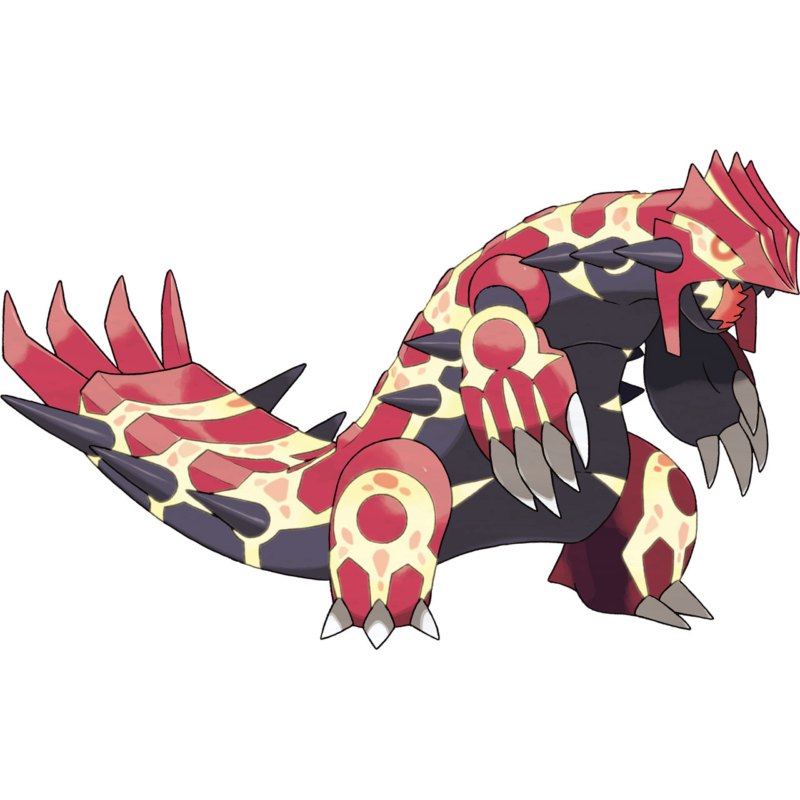

In [27]:
img

In [28]:
for images, captions in train_dataloader:
    for image in images:
        for captionT in captions:
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            
            # Unnormalize
            unnormalized = image * std + mean  # Now in [0,1] again
            
            # Clamp to valid range
            unnormalized = unnormalized.clamp(0, 1)
    
            # Convert to PIL image
            img = to_pil_image(unnormalized)

            caption = generate_caption(model, image, idx2text, device, max_len=20)

            caption_words = [idx2text.get(token.item()) for token in captionT]
        
            caption_clean = [word for word in caption_words if word not in ["SOS", "EOS", "PAD"]]
            caption_clean = " ".join(caption_clean)
            print("Standard Caption:", caption_clean)
            print("Generated Caption:", caption)
            break
        break
    break

Standard Caption: A cartoon character with a red mohawk and a yellow body.
Generated Caption: A cartoon character with a red mohawk and a yellow body.


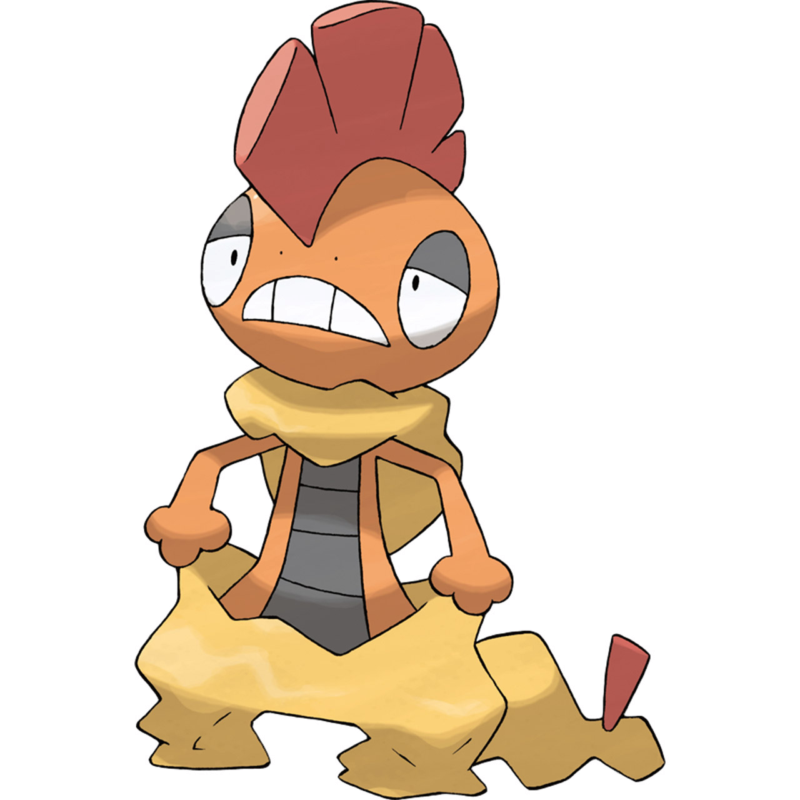

In [29]:
img

In [30]:
# For inference, assume you have an image (here we use a dummy image).
# dummy_image = torch.rand(3, 224, 224)
# caption = generate_caption(model, dummy_image, idx2text, device, max_len=20)
# print("Generated Caption:", caption)

In [31]:
img = Image.open("/kaggle/input/pokemon-image-captioning-testing-dataset/charmander.jpg")

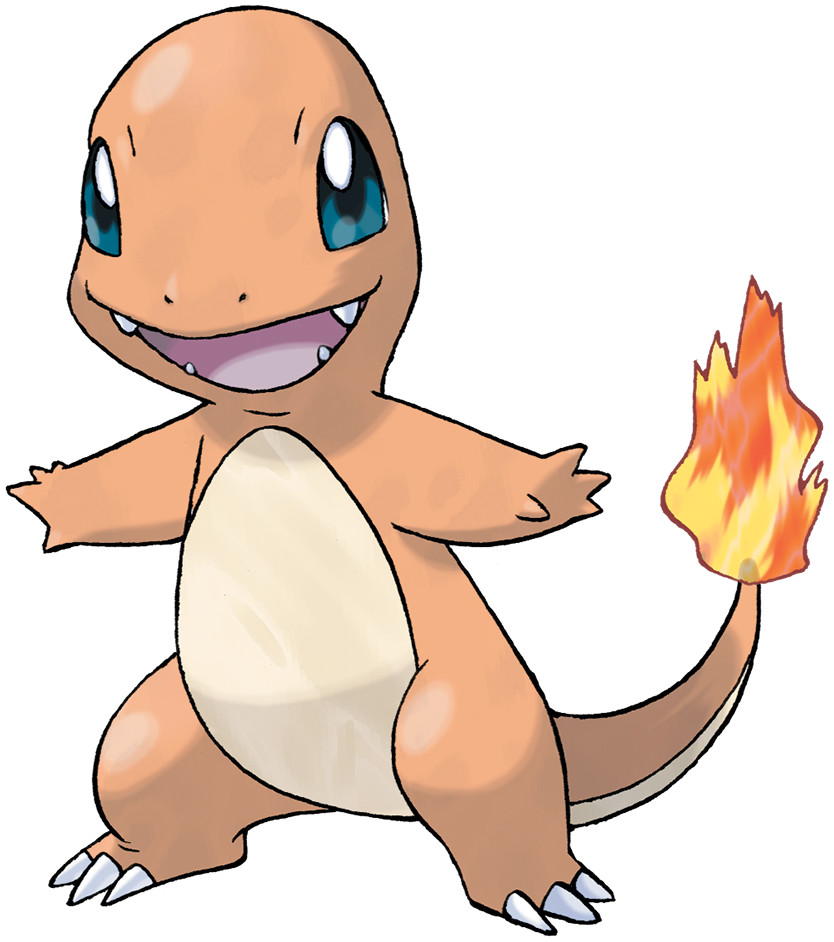

In [32]:
img

In [33]:
img_tensor = transform(img)
caption = generate_caption(model, image, idx2text, device, max_len=20)

print("Generated Caption:", caption)

Generated Caption: A cartoon character with a red mohawk and a yellow body.


# New dataset:

In [34]:
# import os
# from IPython.display import display

In [35]:
# import matplotlib.pyplot as plt

### Define transform

In [36]:
# transform = transforms.Compose([
#     transforms.Resize((800, 800)),
#     transforms.ToTensor(),  # Converts PIL image to tensor [0,1]
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
# ])

In [37]:
# def read_dataset(train_test_val='train'):  # train_test_val is a str: ('train', 'test', 'val')
#     """ Load images """
#     image_folder_path = '/kaggle/input/image-captioning-dataset/custom_captions_dataset/' + train_test_val
#     image_files = os.listdir(image_folder_path)
#     jpg_files = [f for f in image_files if f.lower().endswith('.jpg')]

#     images = []
#     for filename in jpg_files:
#         image_path = os.path.join(image_folder_path, filename)
#         try:
#             img = Image.open(image_path)
#             img_tensor = transform(img)
            
#             images.append([img, filename, img_tensor])  #  images.append([img, filename, img_tensor])

#             img.close()
#             # print(f"Successfully loaded: {filename}, size: {img.size}, format: {img.format}")
#             # You can now work with the 'img' object (e.g., display, process)
#             # img.show()  # To display the image (may not work in all notebook environments)
#             # ... your image processing code ...
#             # img.close() # Close the image file
#         except Exception as e:
#             print(f"Error loading {filename}: {e}")
    
#     print(f"Load image successfully.\nTotal images loaded: {len(images)}")

#     """ Load captions """
#     df = pd.read_csv("/kaggle/input/image-captioning-dataset/custom_captions_dataset/" + train_test_val + ".csv")
#     captions = []
#     for i in range(len(df)):
#         captions.append([df['caption'][i], df['filename'][i]])
    
#     """ Merge """
#     # image_list = [] If want to see image
#     caption_list = []
#     img_tensors = []
#     for filename, img_tensor in images:    # for image, filename, img_tensor in images:
#         for caption, c_filename in captions:
#             if filename == c_filename:
#                 caption = caption.split('.')
#                 for sen in caption:
#                     # Normalize sen
#                     idx = -1
#                     for i, ch in enumerate(sen):
#                         if ch != ' ':
#                             idx = i
#                             break
#                     if idx != -1:
#                         # image_list.append(image)
#                         caption_list.append(sen[idx:])
#                         img_tensors.append(img_tensor)
#                         break # Just read the first caption
            
#                 break
#     return {'caption': caption_list, 'img_tensor': img_tensors} # Is a dictionart with 2 key 'image' and 'caption'

In [38]:
# test_data = read_dataset('test')

In [39]:
# train_data = read_dataset('train')

In [40]:
# test_data['img_tensor'][510]

In [41]:
# print(train_data['caption'][510])

### My dataset

In [42]:
# import torch
# from torch.utils.data import Dataset

# # --- Vocabulary Building ---
# def build_vocab(captions):
#     vocab = {}
#     idx = 4  # Starting index for words.
#     for seq in captions:
#         for word in seq.split():
#             if word not in vocab:
#                 vocab[word] = idx
#                 idx += 1

#     # Define special tokens.
#     vocab['PAD'] = 0
#     # vocab['UNK'] = 1
#     vocab['SOS'] = 2
#     vocab['EOS'] = 3

#     idx2text = {value: key for key, value in vocab.items()}

#     return vocab, idx2text

# # --- Custom Dataset ---
# class MyDataset(Dataset):
#     def __init__(self, images, captions, text2idx):
#         """
#         Args:
#             images: A list (or tensor) of image tensors.
#             captions: A list of caption strings.
#             text2idx: Dictionary mapping words to indices. Must include 'SOS', 'EOS', 'PAD', 'UNK'.
#         """
#         self.images = images
#         self.captions = captions
#         self.text2idx = text2idx

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.images[idx]
#         cap = self.captions[idx]
        
#         tokens = cap.split() # Split the caption into words.
        
#         tokens = ['SOS'] + tokens + ['EOS'] # Append <<start>> and <<end>>
      
#         cap_indices = torch.tensor(
#             [self.text2idx.get(token, self.text2idx['UNK']) for token in tokens], # Unknown
#             dtype=torch.long
#         )
#         return image, cap_indices

# def collate_fn(batch):
#     images, captions = zip(*batch)
    
#     max_len = max(cap.size(0) for cap in captions)
#     pad_token = text2idx['PAD']

#     # Padding 
#     padded_captions = [
#         torch.cat([cap, torch.full((max_len - cap.size(0),), pad_token, dtype=torch.long)])
#         for cap in captions
#     ]
#     images_tensor = torch.stack(images)
#     captions_tensor = torch.stack(padded_captions)
#     return images_tensor, captions_tensor

In [43]:
# text2idx, idx2text = build_vocab(train_data['caption'])
# print(len(text2idx), text2idx['is'])
# print("Vocab OK!")

In [44]:
# train_dataset = MyDataSet(train_data['image'], train_data['caption'], text2idx)
# train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)